**1. Початок роботи.** Для початку завантажимо датасет із kaggle. Датасет містить рентгенівські знімки нормальних легень та пневмонії. Набір даних організовано в 3 папки (train, test, val) і містить підпапки для кожної категорії зображень (Pneumonia/Normal). Набір містить 5,863 рентгенівські знімки (JPEG) та 2 категорії (Пневмонія/Норма) => використато датасет, що і при виконанні лабораторної 1.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emmabrodina","key":"85fe62c3858bf4daf61ea62fd0026321"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 97% 2.22G/2.29G [00:04<00:00, 646MB/s]
100% 2.29G/2.29G [00:05<00:00, 477MB/s]


**2. Зробимо deep dive у дані**, щоб перевірити, яка кількість зображень є в кожній категорії

In [4]:
import os

base_dir = "chest_xray"

for split in ["train", "val", "test"]:
    normal_count = len(os.listdir(os.path.join(base_dir, split, "NORMAL")))
    pneumonia_count = len(os.listdir(os.path.join(base_dir, split, "PNEUMONIA")))
    print(f"{split.upper()} — NORMAL: {normal_count}, PNEUMONIA: {pneumonia_count}")

TRAIN — NORMAL: 1341, PNEUMONIA: 3875
VAL — NORMAL: 8, PNEUMONIA: 8
TEST — NORMAL: 234, PNEUMONIA: 390


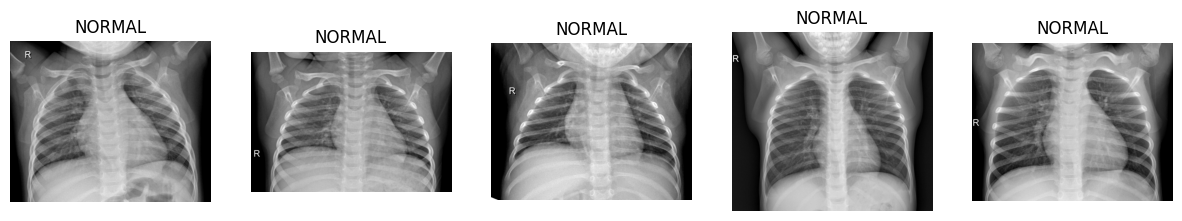

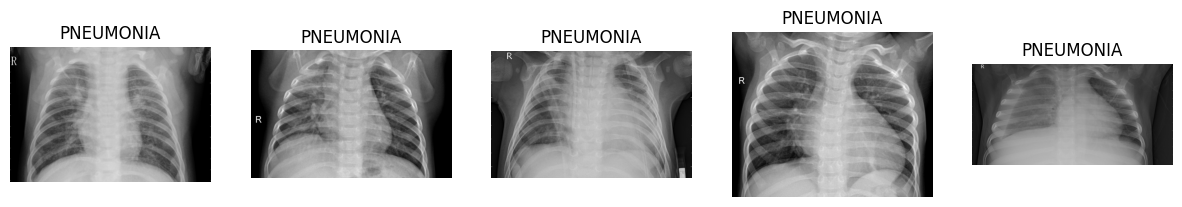

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def plot_sample_images(folder_path, label, n=5):
    files = os.listdir(folder_path)
    samples = random.sample(files, n)

    plt.figure(figsize=(15, 3))
    for i, file in enumerate(samples):
        img = mpimg.imread(os.path.join(folder_path, file))
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

# NORMAL
plot_sample_images("chest_xray/train/NORMAL", "NORMAL")

# PNEUMONIA
plot_sample_images("chest_xray/train/PNEUMONIA", "PNEUMONIA")

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Сирі зображення, без resize / normalize / augmentation
raw_transforms = transforms.ToTensor()

# Завантаження
train_dataset = datasets.ImageFolder("chest_xray/train", transform=raw_transforms)
val_dataset = datasets.ImageFolder("chest_xray/val", transform=raw_transforms)

# Об'єднання train + val
train_dataset.samples += val_dataset.samples
train_dataset.targets += val_dataset.targets

# Тестовий набір
test_dataset = datasets.ImageFolder("chest_xray/test", transform=raw_transforms)

# DataLoaders
train_loader_raw = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader_raw = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Подивимось форму першого зображення
example_img, _ = train_dataset[0]
print("Розмір зображення:", example_img.shape)

Розмір зображення: torch.Size([3, 1858, 2090])


**3. Підготовка даних для побудови Baseline CNN.** У цьому блоці ми готуємо дані для базової моделі. Єдиним кроком попередньої обробки є зменшення розміру зображення до 128×128. Не використовується ні нормалізація, ні аугментація. Це дозволяє оцінити ефективність архітектури CNN при відсутності feature engineering.

In [7]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Трансформація: тільки resize + to_tensor
baseline_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Завантаження
train_dataset1 = datasets.ImageFolder("chest_xray/train", transform=baseline_transforms)
val_dataset1 = datasets.ImageFolder("chest_xray/val", transform=baseline_transforms)

# Об'єднуємо train + val
train_dataset1.samples += val_dataset1.samples
train_dataset1.targets += val_dataset1.targets

# Тест
test_dataset1 = datasets.ImageFolder("chest_xray/test", transform=baseline_transforms)

# DataLoader-и
train_loader1 = DataLoader(train_dataset1, batch_size=32, shuffle=True)
test_loader1 = DataLoader(test_dataset1, batch_size=32, shuffle=False)

**4. Побудова CNN архітектури.** У цьому блоці реалізовано просту згорткову нейронну мережу для класифікації рентгенівських знімків. Архітектура оптимізована під вхід розміром (3, 128, 128). Модель складається з трьох згорткових шарів з ReLU та MaxPooling, за якими йдуть два повнозв'язаних шари.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN128(nn.Module):
    def __init__(self):
        super(CNN128, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # 128x128 → 64 → 32 → 16
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> 64x64
        x = self.pool(F.relu(self.conv2(x)))  # -> 32x32
        x = self.pool(F.relu(self.conv3(x)))  # -> 16x16
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x

**5. Тренування Baseline CNN.** У цьому блоці ми ініціалізуємо модель CNN128, визначаємо функцію втрат та оптимізатор (Adam). Навчання проводимо протягом 10 епох без early stopping, оскільки в цьому етапі ми оцінюємо базову продуктивність моделі без оптимізацій або регуляризації.

In [9]:
import torch
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Пристрій
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ініціалізація моделі
model1 = CNN128().to(device)

# Loss і оптимізатор
criterion1 = nn.BCELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)

# Функція тренування
def train_baseline(model, train_loader, test_loader, criterion, optimizer, device, epochs=10):
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Епоха {epoch+1}/{epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Тест
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / total)

        print(f"Епоха {epoch+1}: Train Loss = {train_losses[-1]:.4f}, "
              f"Test Loss = {test_losses[-1]:.4f}, Test Acc = {test_accuracies[-1]:.4f}")

    return train_losses, test_losses, test_accuracies

# Запуск тренування
train_loss1, test_loss1, test_acc1 = train_baseline(
    model1, train_loader1, test_loader1,
    criterion1, optimizer1, device, epochs=10
)

Епоха 1/10: 100%|██████████| 164/164 [01:15<00:00,  2.17it/s]


Епоха 1: Train Loss = 0.4496, Test Loss = 0.4586, Test Acc = 0.7676


Епоха 2/10: 100%|██████████| 164/164 [01:14<00:00,  2.21it/s]


Епоха 2: Train Loss = 0.1955, Test Loss = 0.4046, Test Acc = 0.8237


Епоха 3/10: 100%|██████████| 164/164 [01:14<00:00,  2.21it/s]


Епоха 3: Train Loss = 0.1418, Test Loss = 0.6685, Test Acc = 0.7724


Епоха 4/10: 100%|██████████| 164/164 [01:14<00:00,  2.21it/s]


Епоха 4: Train Loss = 0.1216, Test Loss = 0.5756, Test Acc = 0.8061


Епоха 5/10: 100%|██████████| 164/164 [01:14<00:00,  2.21it/s]


Епоха 5: Train Loss = 0.1147, Test Loss = 0.6408, Test Acc = 0.7933


Епоха 6/10: 100%|██████████| 164/164 [01:14<00:00,  2.21it/s]


Епоха 6: Train Loss = 0.1054, Test Loss = 0.8207, Test Acc = 0.7708


Епоха 7/10: 100%|██████████| 164/164 [01:14<00:00,  2.21it/s]


Епоха 7: Train Loss = 0.0974, Test Loss = 0.9072, Test Acc = 0.7692


Епоха 8/10: 100%|██████████| 164/164 [01:14<00:00,  2.21it/s]


Епоха 8: Train Loss = 0.0897, Test Loss = 1.3268, Test Acc = 0.7083


Епоха 9/10: 100%|██████████| 164/164 [01:14<00:00,  2.21it/s]


Епоха 9: Train Loss = 0.0952, Test Loss = 0.9818, Test Acc = 0.7596


Епоха 10/10: 100%|██████████| 164/164 [01:14<00:00,  2.21it/s]


Епоха 10: Train Loss = 0.0803, Test Loss = 1.0719, Test Acc = 0.7676


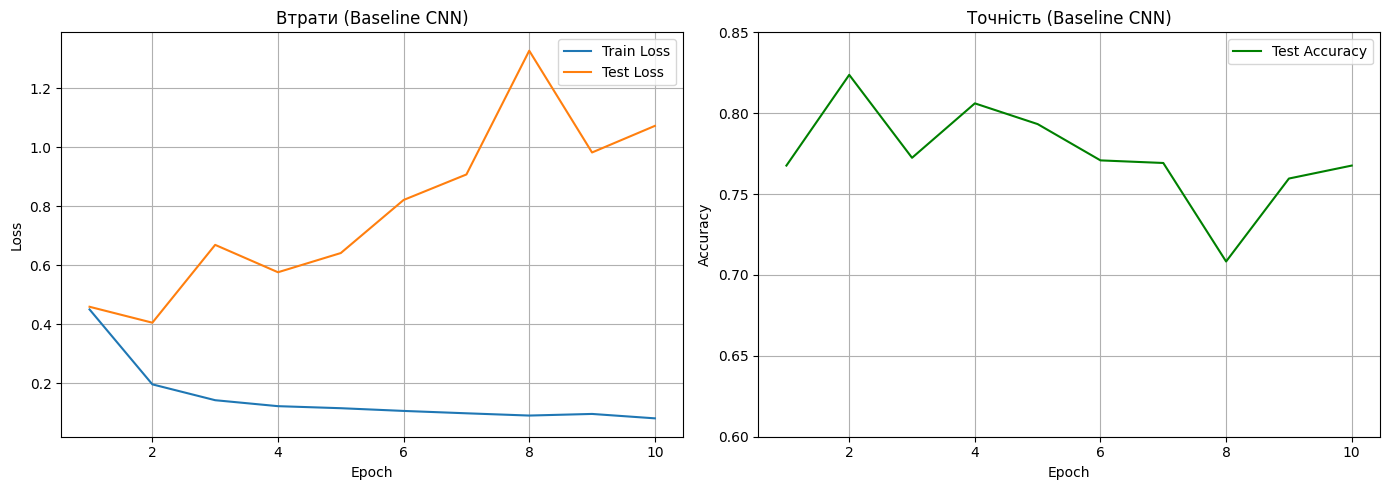

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss1) + 1)

plt.figure(figsize=(14, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss1, label='Train Loss')
plt.plot(epochs, test_loss1, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Втрати (Baseline CNN)")
plt.legend()
plt.grid(True)

# Графік точності
plt.subplot(1, 2, 2)
plt.plot(epochs, test_acc1, label='Test Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Точність (Baseline CNN)")
plt.ylim(0.6, 0.85)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Бачимо, що тренувальний loss поступово знижується, тобто модель все ж навчається, однак після 2 епохи вже починається перенавчання.

In [12]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

# Точність моделі 1
test_acc_final_1 = evaluate_model(model1, test_loader1, device)
print(f"Загальна точність Baseline CNN: {test_acc_final_1:.4f}")

Загальна точність Baseline CNN: 0.7676


**6. Feature Engineering.** Для другої моделі застосовано повний цикл feature engineering: зображення масштабуються до 128×128, нормалізуються та піддаються аугментаціям (повороти, зсуви, зміни яскравості).

In [13]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# === FEATURE ENGINEERING ===
train_transforms2 = transforms.Compose([

    # Resize — уніфікація розміру зображень
    transforms.Resize((128, 128)),

    # Аугментація: горизонтальне віддзеркалення
    transforms.RandomHorizontalFlip(p=0.5),

    # Аугментація: поворот + зсув + масштабування
    transforms.RandomAffine(
        degrees=15,               # випадковий поворот в межах ±15°
        translate=(0.05, 0.05),   # горизонтальний/вертикальний зсув до 5%
        scale=(0.95, 1.05)        # масштабування ±5%
    ),

    # Аугментація: варіації яскравості й контрасту
    transforms.ColorJitter(
        brightness=0.1,           # до ±10% зміна яскравості
        contrast=0.1              # до ±10% зміна контрасту
    ),

    # Перетворення у тензор
    transforms.ToTensor(),

    # Нормалізація — приведення значень до ∼0 середнього
    transforms.Normalize([0.5], [0.5])  # для 1-канального (grayscale) зображення
])


# === TEST трансформації — тільки базова обробка ===
test_transforms2 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === Завантаження датасетів ===
train_dataset2 = datasets.ImageFolder("chest_xray/train", transform=train_transforms2)
val_dataset2   = datasets.ImageFolder("chest_xray/val", transform=train_transforms2)
test_dataset2  = datasets.ImageFolder("chest_xray/test", transform=test_transforms2)

# Об'єднання train + val
train_dataset2.samples += val_dataset2.samples
train_dataset2.targets += val_dataset2.targets

# === DataLoader-и ===
batch_size = 32
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_loader2  = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

**7. Навчання моделі CNN із Feature Engineering**

In [14]:
def train_with_early_stopping(model, train_loader, test_loader, criterion, optimizer, device,
                              epochs=20, patience=3):
    train_losses = []
    test_losses = []
    test_accuracies = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Епоха {epoch+1}/{epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Тестування
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = test_loss / len(test_loader)
        val_acc = correct / total
        test_losses.append(val_loss)
        test_accuracies.append(val_acc)

        print(f"Епоха {epoch+1}: Train Loss = {train_loss:.4f}, "
              f"Test Loss = {val_loss:.4f}, Test Acc = {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Зупинка тренування: немає покращення {patience} епох поспіль.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return train_losses, test_losses, test_accuracies

In [15]:
# Ініціалізація
model2 = CNN128().to(device)
criterion2 = nn.BCELoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-4)

# Навчання
train_loss2, test_loss2, test_acc2 = train_with_early_stopping(
    model2,
    train_loader2,
    test_loader2,
    criterion2,
    optimizer2,
    device,
    epochs=20,
    patience=3
)

Епоха 1/20: 100%|██████████| 164/164 [01:18<00:00,  2.09it/s]


Епоха 1: Train Loss = 0.3982, Test Loss = 0.3717, Test Acc = 0.8462


Епоха 2/20: 100%|██████████| 164/164 [01:18<00:00,  2.09it/s]


Епоха 2: Train Loss = 0.2269, Test Loss = 0.4246, Test Acc = 0.8365


Епоха 3/20: 100%|██████████| 164/164 [01:18<00:00,  2.08it/s]


Епоха 3: Train Loss = 0.2056, Test Loss = 0.6348, Test Acc = 0.7821


Епоха 4/20: 100%|██████████| 164/164 [01:19<00:00,  2.06it/s]


Епоха 4: Train Loss = 0.1948, Test Loss = 0.5396, Test Acc = 0.8141
Зупинка тренування: немає покращення 3 епох поспіль.


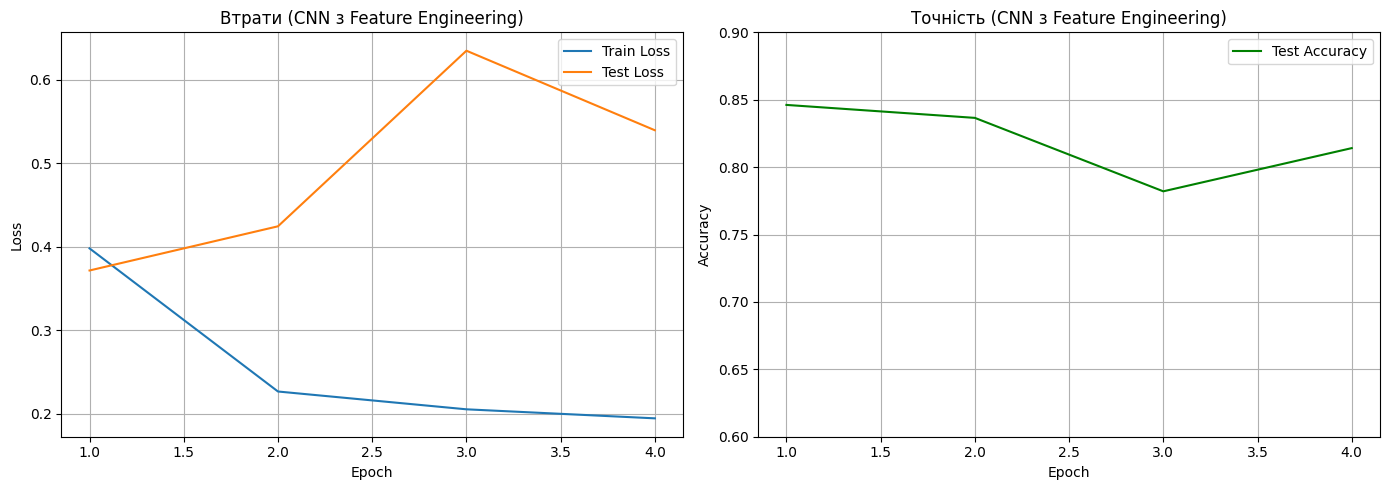

In [17]:
epochs2 = range(1, len(train_loss2) + 1)

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs2, train_loss2, label='Train Loss')
plt.plot(epochs2, test_loss2, label='Test Loss')
plt.title("Втрати (CNN з Feature Engineering)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs2, test_acc2, label='Test Accuracy', color='green')
plt.title("Точність (CNN з Feature Engineering)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.6, 0.9)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Результати по точності краще, але перенавчання також починається після 2ї епохи.

In [18]:
test_acc_final_2 = evaluate_model(model2, test_loader2, device)
print(f"Загальна точність CNN з Feature Engineering: {test_acc_final_2:.4f}")

Загальна точність CNN з Feature Engineering: 0.8141


In [23]:
import pandas as pd

results_df = pd.DataFrame([
    {
        "Model": "Baseline CNN",
        "Max Test Accuracy": max(test_acc1),
        "Final Test Accuracy": test_acc_final_1,
        "Final Test Loss": test_loss1[-1],
        "Epochs Trained": len(test_acc1),
        "Feature Engineering": "Resize only"
    },
    {
        "Model": "CNN з Feature Engineering",
        "Max Test Accuracy": max(test_acc2),
        "Final Test Accuracy": test_acc_final_2,
        "Final Test Loss": test_loss2[-1],
        "Epochs Trained": len(test_acc2),
        "Feature Engineering": "Resize + Normalize + Augment"
    }
])

results_df

,Model,Max Test Accuracy,Final Test Accuracy,Final Test Loss,Epochs Trained,Feature Engineering
0,Baseline CNN,0.823718,0.767628,1.071904,10,Resize only
1,CNN з Feature Engineering,0.846154,0.814103,0.539560,4,Resize + Normalize + Augment


**ВИСНОВОК.** Порівняльний аналіз показує, що застосування feature engineering суттєво покращує якість моделі. **Тестова точність зросла з 76.8% до 81.4%, а максимальна точність — з 82.4% до 84.6%.**